In [1]:
from google.colab import files
import zipfile

# Upload file ZIP
uploaded = files.upload()

# Ekstrak file ZIP
with zipfile.ZipFile("student_dataset cleaned.zip", "r") as zip_ref:
    zip_ref.extractall("data")
    import os
os.listdir("data")

Saving student_dataset cleaned.zip to student_dataset cleaned.zip


['cleaned_data.csv',
 'Students Performance Dataset.json',
 'metadata.xlsx',
 'Students Performance Dataset.csv',
 'scaler.pkl',
 'Students_Grading_Dataset_Biased.json',
 'Students_Grading_Dataset_Biased.csv']

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [3]:
# Load cleaned dataset
df = pd.read_csv("data/cleaned_data.csv")
df.head()

,Projects_Score,Final_Score,Midterm_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Class
0,0.2568,0.326830,0.010168,0.473895,0.063413,0.734,0
1,0.9646,0.566783,0.287881,0.484697,0.964793,0.880,1
2,0.8244,0.397532,0.030672,0.717143,0.000000,0.047,0
3,0.1096,0.073870,0.094182,0.362072,0.325465,0.042,0
4,0.7486,0.362848,0.218870,0.353271,0.679736,0.643,1


In [4]:
df = df.dropna(subset=["Class"])

# Pisahkan fitur dan target
X = df.drop(columns=["Class"])
y = df["Class"]

In [5]:
# Bagi data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [11]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [12]:
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n--- {model_name} ---")
    print(f"Akurasi  : {acc:.4f}")
    print(f"Presisi  : {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


--- Logistic Regression ---
Akurasi  : 0.9824
Presisi  : 0.9711
Recall   : 1.0000
F1-score : 0.9854

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       324
           1       0.97      1.00      0.99       471

    accuracy                           0.98       795
   macro avg       0.99      0.98      0.98       795
weighted avg       0.98      0.98      0.98       795



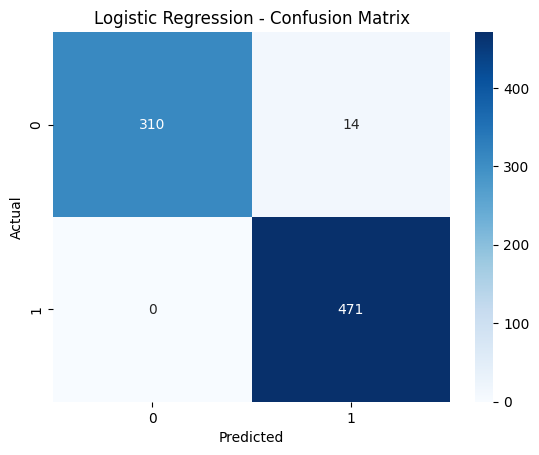


--- Random Forest ---
Akurasi  : 0.9346
Presisi  : 0.9284
Recall   : 0.9639
F1-score : 0.9458

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       324
           1       0.93      0.96      0.95       471

    accuracy                           0.93       795
   macro avg       0.94      0.93      0.93       795
weighted avg       0.93      0.93      0.93       795



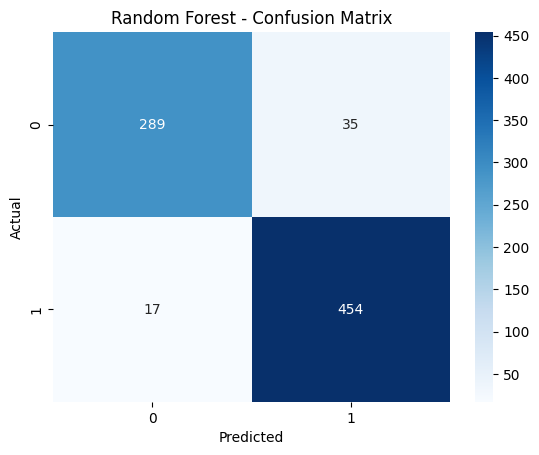

In [13]:
evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")

/tmp/ipython-input-14-2040185921.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


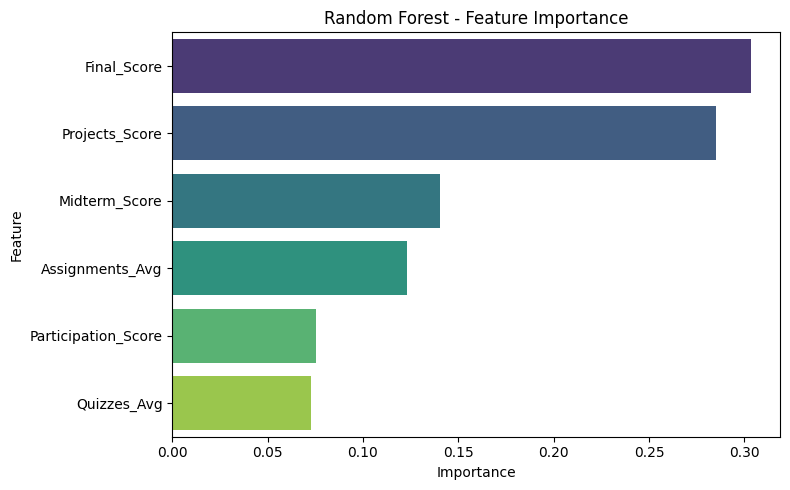

In [14]:
# Visualisasi Feature Importance
importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Random Forest - Feature Importance")
plt.tight_layout()
plt.show()

In [26]:
# K-Means
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X_clust = df.drop(columns='Class')
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_clust)

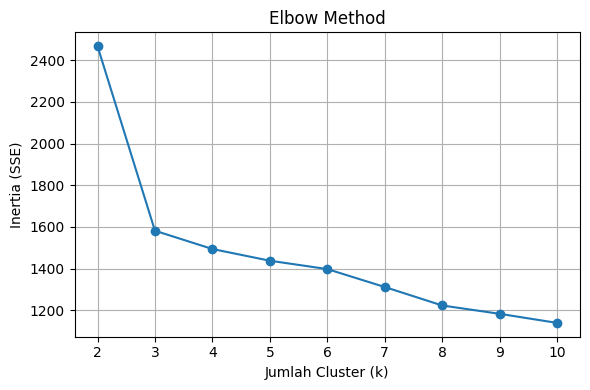


Tabel Silhouette Score:
 Jumlah Cluster (k)  Silhouette Score
                  2          0.403448
                  3          0.398215
                  4          0.312919
                  5          0.308234
                  6          0.305059
                  7          0.227215
                  8          0.150830
                  9          0.149659
                 10          0.154128


In [19]:
from sklearn.metrics import silhouette_score

# Elbow & Silhouette
inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_clust)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_clust, labels))

# Plot Elbow
plt.figure(figsize=(6, 4))
plt.plot(K, inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia (SSE)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Tampilkan hasil silhouette
results_df = pd.DataFrame({
    "Jumlah Cluster (k)": list(K),
    "Silhouette Score": silhouette_scores
})
print("\nTabel Silhouette Score:")
print(results_df.to_string(index=False))

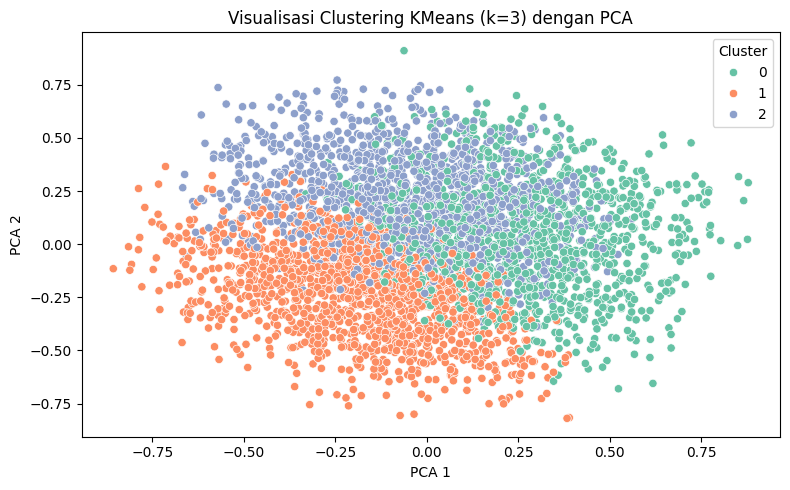

Rata-rata fitur per Cluster:
         Projects_Score  Final_Score  Midterm_Score  Assignments_Avg  \
Cluster                                                                
0              0.695634     0.403505       0.288860         0.530119   
1              0.446870     0.544027       0.616818         0.478204   
2              0.354152     0.524321       0.613384         0.494713   

         Quizzes_Avg  Participation_Score  
Cluster                                    
0           0.575902             0.548159  
1           0.460238             0.220267  
2           0.455621             0.761530  


In [28]:
from sklearn.decomposition import PCA

# --- KMeans dengan 3 Cluster ---
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df.drop(columns='Class'))  # Pastikan 'Class' tidak diikutkan

# --- PCA untuk Visualisasi 2D ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.drop(columns=['Class', 'Cluster']))
df_pca = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = df['Cluster']

# --- Scatter Plot Visualisasi Cluster ---
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("Visualisasi Clustering KMeans (k=3) dengan PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

cluster_features = ['Projects_Score', 'Final_Score', 'Midterm_Score',
                    'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score']

cluster_summary = df.groupby('Cluster')[cluster_features].mean()
print("Rata-rata fitur per Cluster:")
print(cluster_summary)


In [ ]:
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(lr_model, 'logistic_model.pkl')
joblib.dump(kmeans, 'kmeans_model.pkl')

from google.colab import files
files.download('random_forest_model.pkl')
files.download('logistic_model.pkl')
files.download('kmeans_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>